## Wikidata Knowledge Graph Extraction
Many recommendation algorithms (DKN, RippleNet, KGCN) use Knowledge Graphs as an external source of information. We found that one of the bottlenecks to benchmark current algorithms like DKN, RippleNet or KGCN is that they used Microsoft Satori. As Satori is not open source, it's not possible to replicate the results found in the papers. The solution is using other open source KGs.

The goal of this notebook is to provide examples of how to interact with Wikipedia queries and Wikidata to extract a Knowledge Graph that can be used with the mentioned algorithms.

The steps covered are:
- How to find a Wikidata entity (https://www.wikidata.org/wiki/Wikidata:Glossary/en from a text query
- How to find surrounding entities of an entity 
- How to find the description of an entity
- Create a KG for Movielens

In [1]:
# set the environment path to find Recommenders
import sys
sys.path.append("../../")
print("System version: {}".format(sys.version))

import pandas as pd
from reco_utils.dataset.wikidata import (
    find_wikidataID,
    query_entity_links,
    read_linked_entities,
    query_entity_description
)

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

from reco_utils.dataset import movielens
from reco_utils.common.notebook_utils import is_jupyter

System version: 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:55:02) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]


In [5]:
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'
MOVIELENS_SAMPLE = False
MOVIELENS_SAMPLE_SIZE = 5

In [6]:
KG_FILE_NAME = "movielens_" + MOVIELENS_DATA_SIZE + '_wikidata.csv'

## 1. Create a KG from linked entities in Wikidata

In [7]:
names = ["The Godfather", "Al Pacino", "Tom Hanks", "Forrest Gump", "Julia Roberts", "", "My Best Friend's Wedding"]

In [8]:
def wikidata_KG_from_list(names):
    results_list = pd.DataFrame()
    for n in names:
        print(n)
        entity_id = find_wikidataID(n)
        if entity_id != "entityNotFound":
            json_links = query_entity_links(entity_id)
            related_entities,related_names = read_linked_entities(json_links)
            d = pd.DataFrame({
                "name":n,
                "original_entity":[entity_id]* len(related_entities),
                "linked_entities":related_entities,
                "name_linked_entities":related_names})
            results_list = pd.concat([results_list, d])
    return results_list

In [9]:
%%time
results_list = wikidata_KG_from_list(names)
results_list.head()

The Godfather
Al Pacino
Tom Hanks
Forrest Gump
Julia Roberts

My Best Friend's Wedding
CPU times: user 433 ms, sys: 34.4 ms, total: 467 ms
Wall time: 10.9 s


### Visualize KG using networkx

In [10]:
G = nx.from_pandas_edgelist(results_list, 'original_entity', 'linked_entities')

In [11]:
target_names = results_list[["linked_entities", "name_linked_entities"]].drop_duplicates().rename(columns={"linked_entities": "labels", "name_linked_entities": "name"})
source_names = results_list[["original_entity", "name"]].drop_duplicates().rename(columns={"original_entity": "labels"})
names = pd.concat([target_names, source_names])
names = names.set_index("labels")
names = names.to_dict()["name"]

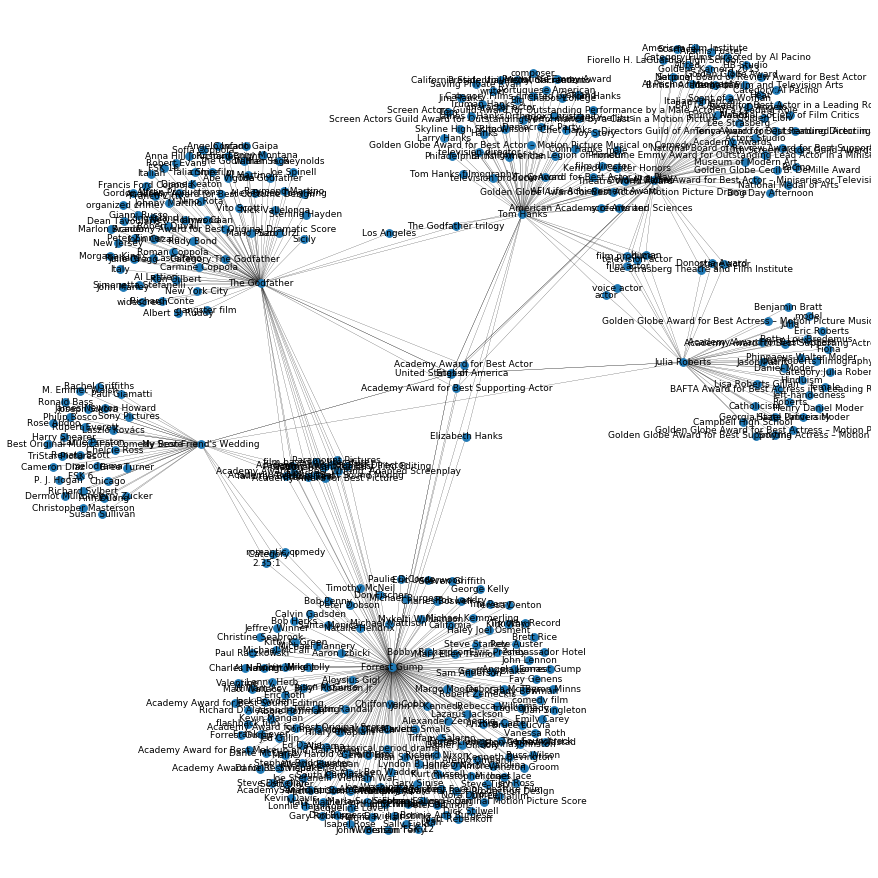

In [12]:
plt.figure(figsize=(12,12)) 
pos = nx.spring_layout(G)
nx.draw(G,pos, node_size=60,font_size=9, width = 0.2)
nx.draw_networkx_labels(G, pos, names, font_size=9)
plt.show()

## 2. Create an item description with short description and linked entitites

In [16]:
# Create entity description with small description and string of linked entities
names = ["The Godfather", "Al Pacino", ""]

In [17]:
def wikidata_descriptions_from_list(names):
    result_description = pd.DataFrame()
    for n in names:
        entity_id = find_wikidataID(n)
        if entity_id != "entityNotFound":
            json_links = query_entity_links(entity_id)
            entity_description = query_entity_description(entity_id)
            related_entities,related_names = read_linked_entities(json_links)
            d = pd.DataFrame({"name": n,
                              "original_entity": entity_id,
                              "description":entity_description,
                              "related_names":', '.join(related_names)}, index = [0])
            result_description = pd.concat([result_description, d])
    return result_description

In [18]:
%%time
result_description = wikidata_descriptions_from_list(names)
result_description.head(10)

CPU times: user 200 ms, sys: 12.5 ms, total: 212 ms
Wall time: 5.33 s


## 3. Create a KG from the Movielens Dataset

In [20]:
# Obtain pairs of Movie Title - IDs from Movielens
df = movielens.load_pandas_df(MOVIELENS_DATA_SIZE,
                              ('UserId', 'ItemId', 'Rating', 'Timestamp'),
                             title_col='Title',
                             genres_col='Genres',
                             year_col='Year'
        )
movies = df[["Title", "ItemId"]].drop_duplicates().reset_index()

100%|██████████| 4.81k/4.81k [00:02<00:00, 1.68kKB/s]


In [21]:
movies["Title"][0:5]

0                  Kolya (1996)
1      L.A. Confidential (1997)
2           Heavyweights (1994)
3    Legends of the Fall (1994)
4           Jackie Brown (1997)
Name: Title, dtype: object

In [22]:
movies.shape

(1682, 3)

In [23]:
def wikidata_KG_from_movielens(df):
    result_linked = pd.DataFrame()
    entity_id = find_wikidataID(df["Title"] + " film")
    if entity_id != "entityNotFound":
        json_links = query_entity_links(entity_id)
        related_entities,related_names = read_linked_entities(json_links)
        d = pd.DataFrame({"original_entity":[entity_id]* len(related_entities),
                          "linked_entities":related_entities,
                          "name_linked_entities":related_names,
                          "movielens_title": df["Title"],
                          "movielens_id": df["ItemId"],
                         })
        result_linked = pd.concat([result_linked, d])
    return result_linked

In [24]:
# For notebook testing
if MOVIELENS_SAMPLE == True:
    movies = movies.loc[0:MOVIELENS_SAMPLE_SIZE-1]

In [25]:
%%time
# tqdm().pandas(desc="Number of movies completed")
# result = pd.concat(list(movies.progress_apply(lambda x: wikidata_KG_from_movielens(x), axis=1)))
result = pd.concat(list(movies.apply(lambda x: wikidata_KG_from_movielens(x), axis=1)))

CPU times: user 400 ms, sys: 25.8 ms, total: 425 ms
Wall time: 9.66 s


In [26]:
result["movielens_title"].value_counts()

L.A. Confidential (1997)      70
Kolya (1996)                  64
Jackie Brown (1997)           51
Legends of the Fall (1994)    45
Heavyweights (1994)           42
Name: movielens_title, dtype: int64

In [23]:
# result.to_csv(KG_FILE_NAME, index = False)

In [27]:
number_movies = len(result["movielens_title"].unique())

In [ ]:
# Record results with papermill for tests - ignore this cell
if is_jupyter():
    # Record results with papermill for unit-tests
    import papermill as pm
    pm.record("lenght_result", number_movies)